#1.Importar librerías e instalar paquetes 






In [ ]:
import pandas as pd #Manejo de dataframes
import numpy as np #Manejo de arrays
import seaborn as sns # Para realización de gráficos
import matplotlib.pyplot as plt # Para realización de gráficos
import zipfile #Para archivos comprimidos
import cv2 #Para imágenes
from skimage import io #Para imágenes
import tensorflow as tf  
from tensorflow.python.keras import Sequential #Contrucción de capas
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.mobilenet import MobileNet #Aprendizaje por transferencia
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model #Creación y cargue del modelo
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files 
%matplotlib inline

#2.Revisar la versión de tensorflow

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

print('Versión de Tensorflow: ' + tf.__version__)

Versión de Tensorflow: 2.8.2


#3.Montar la unidad de drive 

In [ ]:
#Se monta la unidad de drive con el fin de extraer los datos que almacenamos en nuestro Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#4.Se cargan y exploran los datos

In [ ]:
# Se define un dataframe que tiene el etiquetado de las imágenes en defectuosas y no defectuosas
all_images_df = pd.read_csv('/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introducción_Inteligencia_Artificial_Resnet_50/defect_and_no_defect.csv')

##4.1.Análisis exploratorio sobre los datos

Los datos para este trabajo fueron descargados desde https://www.kaggle.com/competitions/severstal-steel-defect-detection/rules

In [ ]:
#Se imprimen las dimensiones del dataframe de las imágenes defectuosas y no defectuosas
all_images_df.shape

(12997, 2)

In [ ]:
#Se revisa el dataframe, donde 1 es defectuosa y cero es no defectuosa en la columna de "label"
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [ ]:
#Dataframe con las imagenes defectuosas 
imagenes_defectuosas=all_images_df["label"]==1
imagenes_defectuosas=all_images_df[imagenes_defectuosas]
imagenes_defectuosas

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
7090,ffcf72ecf.jpg,1
7091,fff02e9c5.jpg,1
7092,fffe98443.jpg,1
7093,ffff4eaa8.jpg,1


In [ ]:
#Dataframe con las imagenes no defectuosas 
imagenes_no_defectuosas=all_images_df["label"]==0
imagenes_no_defectuosas=all_images_df[imagenes_no_defectuosas]
imagenes_no_defectuosas=imagenes_no_defectuosas.reset_index()
imagenes_no_defectuosas=imagenes_no_defectuosas[['ImageID','label']]
imagenes_no_defectuosas

,ImageID,label
0,f86fc3f01.jpg,0
1,f576a4e75.jpg,0
2,f5a1bb561.jpg,0
3,f60a5bc2b.jpg,0
4,f4d41a007.jpg,0
...,...,...
5897,0482ee1d6.jpg,0
5898,04802a6c2.jpg,0
5899,03ae2bc91.jpg,0
5900,04238d7e3.jpg,0


In [ ]:
# Se cuentan las imágenes con y sin defectos. 
#Hay 7095 imágenes defectuosas y 5902 imágenes no defectuosas
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

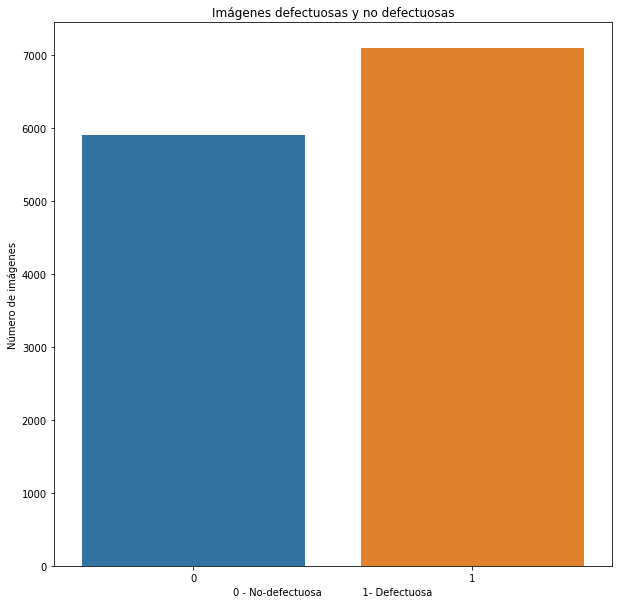

In [ ]:
#Se hace un gráfico de barras en el que se muestra el número de imágenes con base en si es defectuosa o no 
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Número de imágenes')
plt.xlabel('0 - No-defectuosa             1- Defectuosa')
plt.title('Imágenes defectuosas y no defectuosas')
plt.show()

##4.2. Visualización de imágenes defectuosas y no defectuosas

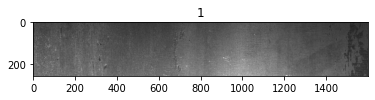

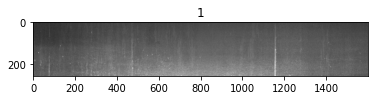

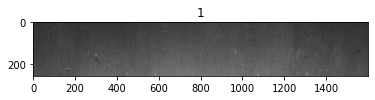

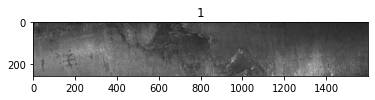

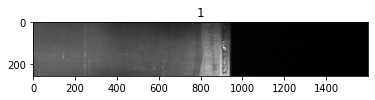

In [ ]:
# Visualizar imágenes con defectos junto con sus etiquetas correspondientes
# Las imágenes son de 256 x 1600
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introducción_Inteligencia_Artificial_Resnet_50/train_images'


for  i in range(5):
  # Especificar el path de las imágenes a partir de su ID de imagen
  img = io.imread(os.path.join(train_dir, imagenes_defectuosas.ImageID[i]))
  plt.figure()
  plt.title(imagenes_defectuosas.label[i])
  plt.imshow(img)

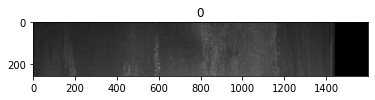

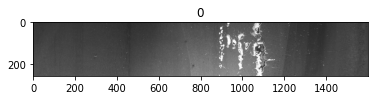

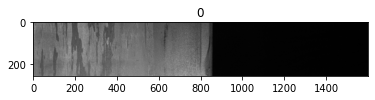

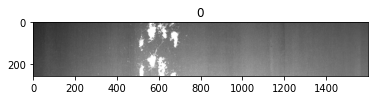

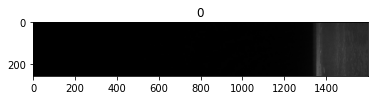

In [ ]:
# Visualizar imágenes sin defectos junto con sus etiquetas correspondientes
# Las imágenes son de 256 x 1600
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introducción_Inteligencia_Artificial_Resnet_50/train_images'

for i in range(5):
  # Especificar el path de las imágenes a partir de su ID de imagen
  img = io.imread(os.path.join(train_dir, imagenes_no_defectuosas.ImageID[i]))
  plt.figure()
  plt.title(imagenes_no_defectuosas.label[i])
  plt.imshow(img)

#5.Construcción del modelo de clasificación

###5.1 División del conjunto de datos

In [ ]:
# Dividir el dataset (defectuosas y no defectousas)  en entrenamiento y testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [ ]:
train.shape

(11047, 2)

In [ ]:
test.shape

(1950, 2)

In [ ]:
train_dir = '/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introducción_Inteligencia_Artificial_Resnet_50/train_images'

###5.2 Creación del generador de imágenes de training, validation y testing

In [ ]:
# Se crea un generador de imágenes para el conjunto de datos de entrenamiento y validación
# Se dividen los datos en entrenamiento, validación y testing.
# Training = 9390, 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# Se crea un generador  que escale los datos de 0 a 1 y se una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (224, 224))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (224, 224))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [ ]:
# Crear un generador de datos para imágenes de test
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (224, 224))


Found 1950 validated image filenames.


#6.Se instancia el modelo pre-entrenado MovilNet

Este modelo en su primera capa recibe imágenes de 224 por 224

In [ ]:
basemodel = MobileNet(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(224,224,3)))

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

#7.Se congelan los pesos del modelo

In [ ]:
# Congelar los pesos del modelo
for layer in basemodel.layers:
  layers.trainable = False

#8.Se construyen las capas top del modelo

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
#Se define el optimizador y la función de pérdida
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

#9.Generación de checkpoints

In [ ]:
# Usar la parada temprana para parar el entrenamiento si la pérdida en validación no baja después de un cierto número de epochs 
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introduccion_Inteligencia_Artificial_MobileNet/resnet-weights_MobileNet.hdf5", verbose=1, save_best_only=True)

#10.Verificar disponibilidad de una GPU

In [ ]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))

GPU encontrada: /device:GPU:0


#11.Entrenamiento con GPU

In [ ]:
import timeit

def entrenamiento_gpu():
  with tf.device('/device:GPU:0'):
    model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 5, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])
  
  return None

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')

Epoch 1/5
586/586 [==============================] - ETA: 0s - loss: 0.3686 - accuracy: 0.8385
Epoch 1: val_loss improved from inf to 0.40252, saving model to /content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introduccion_Inteligencia_Artificial_MobileNet/resnet-weights_MobileNet.hdf5
586/586 [==============================] - 2808s 5s/step - loss: 0.3686 - accuracy: 0.8385 - val_loss: 0.4025 - val_accuracy: 0.8489
Epoch 2/5
586/586 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.8891
Epoch 2: val_loss improved from 0.40252 to 0.35709, saving model to /content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introduccion_Inteligencia_Artificial_MobileNet/resnet-weights_MobileNet.hdf5
586/586 [==============================] - 108s 185ms/step - loss: 0.2639 - accuracy: 0.8891 - val_loss: 0.3571 - val_accuracy: 0.8598
Epoch 3/5
586/586 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9127
Epoch 3: val_loss improved from

#12.Se guarda el modelo entrenado 

In [ ]:
# Guardamos la arquitectura del modelo entrenado

model_json = model.to_json()
with open("/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introduccion_Inteligencia_Artificial_MobileNet/resnet-classifier-model_MobileNet.json","w") as json_file:
  json_file.write(model_json)

#13.Evaluación de la calidad del modelo

In [ ]:
with open('/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introduccion_Inteligencia_Artificial_MobileNet/resnet-classifier-model_MobileNet.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargamos el modelo 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/MyDrive/Proyecto_Inteligencia_Artificial/Proyecto_Introduccion_Inteligencia_Artificial_MobileNet/resnet-weights_MobileNet.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Hacemos la predicción

from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 472s 4s/step


In [ ]:
test_predict

array([[0.9189364 ],
       [0.99552876],
       [0.9764805 ],
       ...,
       [0.9780688 ],
       [0.9962819 ],
       [0.99691963]], dtype=float32)

In [ ]:
# Dado que usamos la función de activación sigmoide al final, nuestro resultado contiene valores continuos de 0 a 1.
# La red se usa  para clasificar si la imagen tiene defecto o no
predict = []

for i in test_predict:
  if i < 0.5: 
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [ ]:
len(predict)

1936

In [ ]:
# como usamos el generador de prueba, limitó las imágenes a 1936, debido al tamaño del lote

original = np.asarray(test.label)[:1936]
len(original)

1936

In [ ]:
# Buscamos la accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.9101239669421488

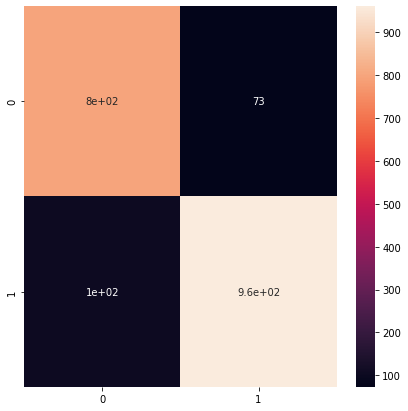

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
plt.show()

In [ ]:
# Imprimimos el reporte de clasificación

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       874
           1       0.93      0.90      0.92      1062

    accuracy                           0.91      1936
   macro avg       0.91      0.91      0.91      1936
weighted avg       0.91      0.91      0.91      1936

